# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Background estimation 


#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective

**Estimate the uncerntainty on the background contamination**, the number of Bi and Tl events, using blind-data.

### Tasks

   * Generate m-large simulation experiments with the estimated number of Bi and Tl events and get the distribution of the number of events of Bi, Tl in RoI

   * Do a likelihood profile scan to estimate the uncertainties in the number Bi and Tl events


## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


In [6]:
nns      = [collpars.nevts_Bi_blind.value, collpars.nevts_Tl_blind.value]
print('Number events from Blind Data Energy fit : Bi = {:6.2f}, Tl = {:6.2f}.'.format(*nns))

Number events from Blind Data Energy fit : Bi = 117.13, Tl = 791.87.


### Parameters of the collaboration - Estimated in previous steps, NBs

## Access the data

In [7]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = '/data/fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
#mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')
datab = pd.read_hdf(dirpath + filename, key = 'data/blind')

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


### Utilities

In [8]:
samples  = ['Bi', 'Tl']
ssamples = [r'$^{214}$Bi', r'$^{208}$Tl']
mcs      = [mcbi, mctl]

## Inspect the variables

In [9]:
#pltext.df_inspect(datab, ncolumns = 3)

## Energy distribution of the blind-data

Plot the energy distribution of the blind-data

### Generate MC-blind samples

Generate MC sample without events in the blind region.

The function *selection_blind(mc)* returns the selection with the blind events

Plot the energy

In [10]:
sels_blind = [fn.selection_blind(mc) for mc in mcs]
mcs_blind  = [mc[sel] for mc, sel in zip(mcs, sels_blind)]
for i, mc in enumerate(mcs):
    print('number of events {:s}: total {:d} in blind data {:d}'.format(samples[i], len(mcs[i]), len(mcs_blind[i])))

number of events Bi: total 60184 in blind data 53758
number of events Tl: total 687297 in blind data 674815


### Generate a random experiment using combined pdfs and do a fit

Construct an 'Extended Combined PDF' object (see class ExtComPDF in module efit.py). 

This object can generate random events (*rvs* method), provides the PDF (*pdf* method), the extended log likelihood (*loglike*) and even the fit to a best estimate (*best_estimate*).

Internally it uses the module *optimize* of *scipy* ([see](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)). 

Here an example with our previously construced PDFs of each sample.

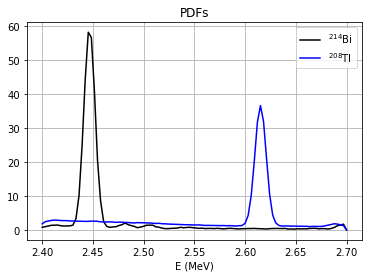

In [11]:
bins = 100
# generate the PDFs of the mcsblind DFs making histograms
pdfs = []
varname  = 'E' 
varrange = erange
for mc in mcs_blind:
    histo = np.histogram(mc[varname], bins, range = varrange);
    pdf = stats.rv_histogram( histo )
    pdfs.append(pdf)

xs   = np.linspace(*varrange, bins)
for i, pdf in enumerate(pdfs): 
    plt.plot(xs, pdf.pdf(xs), label = ssamples[i])
plt.grid(); plt.legend(); 
plt.xlabel('E (MeV)'); plt.title('PDFs');

In [12]:
def experiment(pdfs, nns, verbose = False):
    if (verbose):
        print('Initial parameters     : {:6.2f}, {:6.2f}'.format(*nns))
    ell = efit.ExtComPDF(pdfs, *nns)
    # generate a random experiment
    xs  = ell.rvs()
    # plot the random events
    if (verbose):
        _, edges, _ = pltext.hist(xs, 100, label = 'experiment');

    # fit using the Extended Log Likelihood
    res = ell.best_estimate(xs, *nns)
    # access the information of the 'res' Result Object (see )
    if (verbose):
        print('Fit success? {:s},\nEstimated parameters: {:6.2f}, {:6.2f}'.format(str(res.success), *res.x))

    # overplot the fit result
    ns_est  = res.x
    if (verbose):
        centers = 0.5 * (edges[1:] + edges[:-1])
        scale   = np.sum(ns_est) * (edges[1] - edges[0])
        pdf     = ell.pdf # access to the pdf function inside the composite-PDF object
        plt.plot(centers, scale * pdf(centers, *ns_est), label = 'fit')
        plt.legend();
    return res

Initial parameters     : 117.13, 791.87
Fit success? True,
Estimated parameters: 133.20, 804.80
Fit success? True,
Estimated parameters: 133.20, 804.80


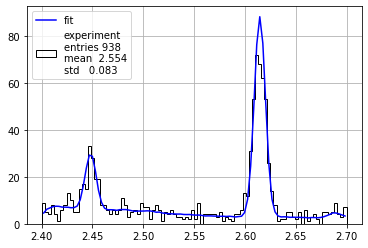

In [13]:
res = experiment(pdfs, nns, True)
print('Fit success? {:s},\nEstimated parameters: {:6.2f}, {:6.2f}'.format(str(res.success), *res.x))

In [14]:
nexperiments = 1000
est_pars     = []
for i in range(nexperiments):
    if (i%100 == 0): print('generating experiment number ', i)
    res = experiment(pdfs, nns)
    if (res.success == True): est_pars.append(res.x)

generating experiment number  0
generating experiment number  100
generating experiment number  200
generating experiment number  300
generating experiment number  400
generating experiment number  500
generating experiment number  600
generating experiment number  700
generating experiment number  800
generating experiment number  900


Uncertainty in number of Bi in blind sample 15.535
Uncertainty in number of Tl in blind sample 30.594


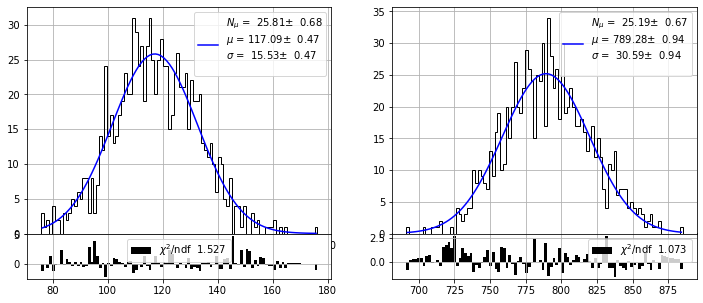

In [15]:
nbis = [x[0] for x in est_pars]
ntls = [x[1] for x in est_pars]

subplot = pltext.canvas(2)
subplot(1)
bipars, _, _, _ = pltext.hfitres(nbis, 100, fun = 'gaus')
subplot(2)
tlpars, _, _, _ = pltext.hfitres(ntls, 100, fun = 'gaus')

unevts_Bi_blind = bipars[2]
unevts_Tl_blind = tlpars[2]
print('Uncertainty in number of Bi in blind sample {:6.3f}'.format(unevts_Bi_blind))
print('Uncertainty in number of Tl in blind sample {:6.3f}'.format(unevts_Tl_blind))

Computing the uncertainties in the number of Bkg events in the RoI

In [16]:
from ana.collpars import eff_Bi_blind, eff_Bi_RoI, eff_Tl_blind, eff_Tl_RoI

unevts_Bi = unevts_Bi_blind/(eff_Bi_blind)
unevts_Tl = unevts_Bi_blind/(eff_Tl_blind)

unevts_Bi_RoI = unevts_Bi_blind * eff_Bi_RoI
unevts_Tl_RoI = unevts_Bi_blind * eff_Tl_RoI

print('Uncertainty in number of Bi {:6.3f}'.format(unevts_Bi))
print('Uncertainty in number of Tl {:6.3f}'.format(unevts_Tl))

print('Uncertainty in number of Bi {:6.3f}'.format(unevts_Bi_RoI))
print('Uncertainty in number of Tl {:6.3f}'.format(unevts_Tl_RoI))

Uncertainty in number of Bi 19.590
Uncertainty in number of Tl 21.911
Uncertainty in number of Bi  0.241
Uncertainty in number of Tl  0.003


## Do a Profile Likelihood Scan

We compute the uncertainties usign the log Likelihood scan

The uncertainties on $\mu$, in the gaussian domain, when there are to parameters to fit $\mu, \nu$, are defined as the points where:

$$
-2 \, \mathrm{log} \frac{\mathcal{L}(x | \mu, \hat{\nu}(\mu))}{\mathcal{L}(x | \hat{\mu}, \hat{\nu})} = 2 \left( \mathrm{log}\mathcal{L}(x | \hat{\mu}, \hat{\nu}) -  \mathrm{log}\mathcal{L}(x | \mu, \hat{\nu}(\mu)\right) = 1
$$

Here from simplicity we take $\hat{\nu}(\mu) = \hat{\nu}$.

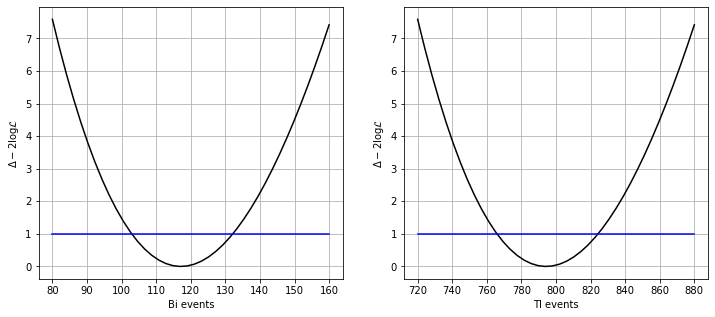

In [17]:
nbi, ntl = nns
ell      = efit.ExtComPDF(pdfs, *nns)
sel      = ut.selection(datab, 'E', erange)
enes     = datab[sel].E.values
nbins    = 40

nbis     = np.linspace(80 , 160, nbins)
ntls     = np.linspace(720, 880, nbins)

llbest   =  -2 * ell.loglike(enes, nbi, ntl)
bi_lls   = [-2 * ell.loglike(enes, ni , ntl) for ni in nbis]
bi_dlls  = np.array(bi_lls)-llbest
tl_lls   = [-2 * ell.loglike(enes, ni , ntl) for ni in nbis]
tl_dlls  = np.array(tl_lls)-llbest

subplot = pltext.canvas(2)
subplot(1)
plt.grid(); plt.xlabel('Bi events'); plt.ylabel(r'$\Delta -2 \mathrm{log} \mathcal{L}$')
plt.plot(nbis, bi_dlls);
plt.plot(nbis, np.ones(nbins), '-');

subplot(2)
plt.grid(); plt.xlabel('Tl events'); plt.ylabel(r'$\Delta -2 \mathrm{log} \mathcal{L}$')
plt.plot(ntls, tl_dlls);
plt.plot(ntls, np.ones(nbins), '-');